# 1. Introduction et préparation

## 1.1. Importation des packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import ensemble 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# Evaluation Metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook, tnrange
from sklearn.model_selection import train_test_split
import yellowbrick
from yellowbrick.text import TSNEVisualizer
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import time
np.random.seed(10)

## 1.2. Chargement des données

In [2]:
amazon = pd.read_csv(r'C:\Users\Bastien\Desktop\Data - Rapport\0. Base de données\1. Saved versions\amazon_reviews_balanced_prepro.csv',sep=',',encoding='utf-8')
amazon = amazon.dropna(subset=['CleanedText'])
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]
amazon['Positivité'].value_counts()

5    39167
4    39143
3    39081
1    39019
2    38957
Name: Positivité, dtype: int64

## 1.3. Séparation des données en jeu de tests et d'entrainements

In [3]:
import random
def shuffle(df):
    index = list(df.index)
    random.shuffle(index)
    df = df.loc[index]
    df = df.reset_index()
    df = df.loc[:, ~df.columns.str.contains('^index')]
    return df

In [4]:
rating_5 = amazon[amazon['Positivité']==5]
rating_4 = amazon[amazon['Positivité']==4]
rating_3 = amazon[amazon['Positivité']==3]
rating_2 = amazon[amazon['Positivité']==2]
rating_1 = amazon[amazon['Positivité']==1]

rating_5 = shuffle(rating_5)
rating_4 = shuffle(rating_4)
rating_3 = shuffle(rating_3)
rating_2 = shuffle(rating_2)
rating_1 = shuffle(rating_1)

In [5]:
rating_5 = rating_5[0:6000]
rating_4 = rating_4[0:6000]
rating_3 = rating_3[0:6000]
rating_2 = rating_2[0:6000]
rating_1 = rating_1[0:6000]

In [6]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(rating_5['CleanedText_With_Stop'], rating_5['Positivité'], test_size = 0.3, shuffle = False)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(rating_4['CleanedText_With_Stop'], rating_4['Positivité'], test_size = 0.3, shuffle = False)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(rating_3['CleanedText_With_Stop'], rating_3['Positivité'], test_size = 0.3, shuffle = False)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(rating_2['CleanedText_With_Stop'], rating_2['Positivité'], test_size = 0.3, shuffle = False)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(rating_1['CleanedText_With_Stop'], rating_1['Positivité'], test_size = 0.3, shuffle = False)

X_train = pd.concat([X_train_5,X_train_4,X_train_3,X_train_2,X_train_1],axis=0,ignore_index=True)
X_test = pd.concat([X_test_5,X_test_4,X_test_3,X_test_2,X_test_1],axis=0,ignore_index=True)
Y_train = pd.concat([y_train_5,y_train_4,y_train_3,y_train_2,y_train_1],axis=0,ignore_index=True)
Y_test = pd.concat([y_test_5,y_test_4,y_test_3,y_test_2,y_test_1],axis=0,ignore_index=True)

In [7]:
X_train.shape

(21000,)

# 2. Détermination de la forme des variables d'entrées

## 2.1. Introduction au problème - la présentation et le pré-traitement des données est disponioble dans les notebooks précédents (0. et 1.)

## 2.2. Fonction pour la régréssions logistique et pour la mesure de performance 

In [389]:
def LogReg(model_name,C_range,penalty_range,X_train,Y_train,X_test,Y_test,truncated):
    start = time.time()
    if truncated == True :
        lsa = TruncatedSVD(n_components=100, n_iter=10, random_state=3)
        #scl = StandardScaler(with_mean=True)
        logreg = LogisticRegression()
        #clf = Pipeline([('svd',lsa),('scl', scl), ('lr', logreg)])
        clf = Pipeline([('svd',lsa), ('lr', logreg)])
    elif truncated == False :
        #scl = StandardScaler(with_mean=True)
        logreg = LogisticRegression()
        #clf = Pipeline([('scl', scl), ('lr', logreg)])
        clf = Pipeline([('lr', logreg)])
        
    params = {'lr__C': C_range, 'lr__penalty': penalty_range}
    gs = GridSearchCV(estimator=clf, param_grid=params, scoring='f1_macro',verbose=10, n_jobs=-1, iid=True, refit=True, cv=5)
    gs.fit(X_train, Y_train)  
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    end = time.time()
    best_model = gs.best_estimator_
    best_model.fit(X_train,Y_train)
    Y_pred = best_model.predict(X_test)
    
    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro')
    rec = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='macro')
    print(classification_report(Y_test, Y_pred))

    table = [[model_name,acc,prec,rec,f1,(end-start)/60]]

    table = pd.DataFrame(table, columns = ["Modèle", "Accuracy","Precision",'Recall',"F1-score","Computing time (minutes)"]) 
    return table, Y_pred

In [9]:
def confusion_matrix_p(Y_test,Y_pred):
    df_cm = pd.DataFrame(cm(Y_test,Y_pred))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

## 2.3. Détermination Avec/Sans Stopwords 
#### Paramètres Stables : CountVectorizer - Réductions de dimensions

### 2.3.1. On conserve les stopwords

In [10]:
# Vectorisation avec la méthode du comptage
count = CountVectorizer()
count.fit(X_train) # On entraîne le vectorizer seulement sur le jeu d'entraînement
X_train_count = count.transform(X_train)
X_test_count = count.transform(X_test)

In [160]:
LR_Count_w_stop = LogReg("Logistic Regression + StopWords + Count + Truncated",[0.1,1,10,100],['l1', 'l2'],X_train_count,Y_train,X_test_count,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  3.1min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.2min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.389
Best parameters set:
	lr__C: 1
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [161]:
LR_Count_w_stop[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + StopWords + Count + Trun...,0.413778,0.399883,0.413778,0.395995,3.330849


None


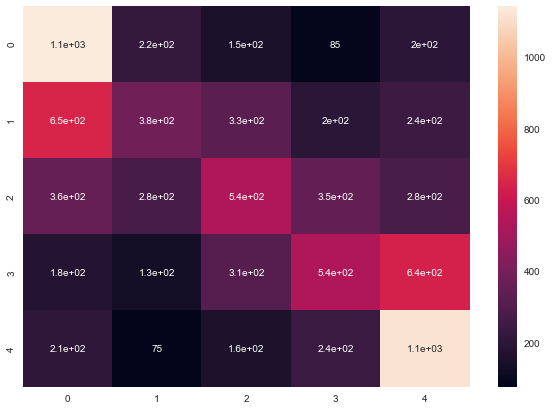

In [162]:
print(confusion_matrix_p(Y_test,LR_Count_w_stop[1]))

### 2.3.2. On enleve les stopwords

In [163]:
X_train_no_sw_5 = rating_5['CleanedText'][X_train_5.index]
X_test_no_sw_5 = rating_5['CleanedText'][X_test_5.index]

X_train_no_sw_4 = rating_4['CleanedText'][X_train_4.index]
X_test_no_sw_4 = rating_4['CleanedText'][X_test_4.index]

X_train_no_sw_3 = rating_3['CleanedText'][X_train_3.index]
X_test_no_sw_3 = rating_3['CleanedText'][X_test_3.index]

X_train_no_sw_2 = rating_2['CleanedText'][X_train_2.index]
X_test_no_sw_2 = rating_2['CleanedText'][X_test_2.index]

X_train_no_sw_1 = rating_1['CleanedText'][X_train_1.index]
X_test_no_sw_1 = rating_1['CleanedText'][X_test_1.index]

In [331]:
X_train_no_sw_2

0       ['plastic', 'process', 'use', 'make', 'pry', '...
1       ['slightly', 'disappointing', 'buy', 'day', 'u...
2       ['order', 'pack', 'regular', 'hanes', 'size', ...
3       ['shoe', 'beautiful', 'love', 'retro', 'style'...
4       ['fit', 'describe', 'arrive', 'however', 'wash...
5       ['white', 'look', 'like', 'spray', 'paint', 'e...
6       ['look', 'fairy', 'tail', 'lovely', 'image', '...
7       ['pant', 'exact', 'size', 'brand', 'fit', 'gre...
8       ['pretty', 'nice', 'knife', 'one', 'major', 'i...
9       ['seem', 'decent', 'case', 'material', 'good',...
10      ['benn', 'playing', 'cord', 'change', 'phone',...
11      ['glass', 'fit', 'comfortably', 'still', 'fogg...
12      ['fabric', 'heavier', 'expect', 'fall', 'fabri...
13      ['mine', 'come', 'broken', 'plastic', 'brittle...
14      ['first', 'one', 'receive', 'use', 'scratch', ...
15      ['goggles', 'ok', 'would', 'recommend', 'use',...
16      ['take', 'three', 'find', 'one', 'work', 'stil...
17      ['well

In [332]:
X_train_2

0       ['the', 'plastic', 'or', 'process', 'use', 'to...
1       ['slightly', 'disappoint', 'this', 'buy', 'a',...
2       ['i', 'order', 'a', 'pack', 'of', 'regular', '...
3       ['shoe', 'be', 'beautiful', 'love', 'this', 'r...
4       ['fit', 'a', 'described', 'when', 'arrive', 'h...
5       ['the', 'white', 'look', 'like', 'it', 'be', '...
6       ['this', 'look', 'fairy', 'tail', 'lovely', 'i...
7       ['i', 'have', 'other', 'pant', 'in', 'this', '...
8       ['pretty', 'nice', 'knife', 'with', 'one', 'ma...
9       ['seem', 'to', 'be', 'a', 'decent', 'case', 'm...
10      ['i', 'have', 'benn', 'play', 'with', 'this', ...
11      ['the', 'glass', 'fit', 'comfortably', 'but', ...
12      ['the', 'fabric', 'be', 'heavy', 'than', 'i', ...
13      ['mine', 'come', 'broken', 'the', 'plastic', '...
14      ['the', 'first', 'one', 'i', 'receive', 'be', ...
15      ['these', 'goggles', 'be', 'ok', 'i', 'would',...
16      ['it', 'take', 'three', 'until', 'i', 'find', ...
17      ['well

In [164]:
X_train_no_sw = pd.concat([X_train_no_sw_5,X_train_no_sw_4,X_train_no_sw_3,X_train_no_sw_2,X_train_no_sw_1],axis=0,ignore_index=True)
X_test_no_sw = pd.concat([X_test_no_sw_5,X_test_no_sw_4,X_test_no_sw_3,X_test_no_sw_2,X_test_no_sw_1],axis=0,ignore_index=True)

In [165]:
# Vectorisation avec la méthode du comptage
count = CountVectorizer()
count.fit(X_train_no_sw) # On entraîne le vectorizer seulement sur le jeu d'entraînement
X_train_wo_count = count.transform(X_train_no_sw)
X_test_wo_count = count.transform(X_test_no_sw)

In [166]:
LR_Count = LogReg("Logistic Regression Without Stopwords + Count",[0.1,1,10,100],['l1', 'l2'],X_train_wo_count,Y_train,X_test_wo_count,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  2.9min remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.368
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [167]:
LR_Count[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression Without Stopwords + Count,0.385222,0.371288,0.385222,0.364317,3.050929


None


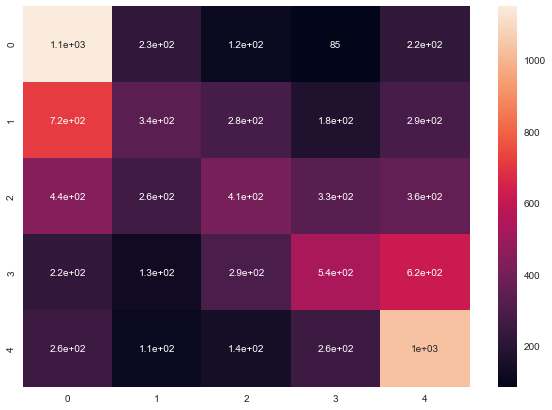

In [168]:
print(confusion_matrix_p(Y_test,LR_Count[1]))

## 2.4. Détermination Réduction de dimension ou non 
#### Paramètres Stables : Conservation des stopwords - CountVectorizer

In [169]:
LR_Count_Bis = LogReg("Logistic Regression With Stopwords + Count",[0.001,0.1,1,10],['l1', 'l2'],X_train_count,Y_train,X_test_count,Y_test,truncated=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  4.3min remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.451
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l1'


In [170]:
LR_Count_Bis[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression With Stopwords + Count,0.465556,0.452797,0.465556,0.453664,5.02115


None


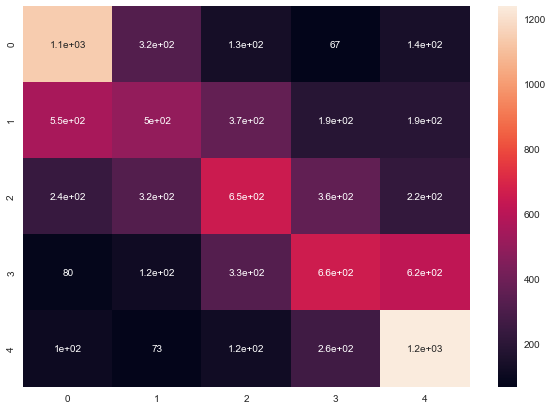

In [171]:
print(confusion_matrix_p(Y_test,LR_Count_Bis[1]))

## 2.5. Tableau récapitulatif et premiers choix

In [172]:
recap_1 = pd.concat([LR_Count_w_stop[0],LR_Count[0],LR_Count_Bis[0]],ignore_index=True)
columnsTitles = ['Modèle', 'Accuracy', 'Precision','Recall', 'F1-score','Computing time (minutes)']
recap_1 = recap_1.reindex(columns = columnsTitles)
recap_1

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + StopWords + Count + Trun...,0.413778,0.399883,0.413778,0.395995,3.330849
1,Logistic Regression Without Stopwords + Count,0.385222,0.371288,0.385222,0.364317,3.050929
2,Logistic Regression With Stopwords + Count,0.465556,0.452797,0.465556,0.453664,5.021150


# 3. Word Embeddings avec la régression logistique

## 3.1. Vectorization TF-IDF et logistique régression

In [173]:
# Vectorisation avec la méthode TF-IDF
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train) # On entraîne le tf-idf seulement sur le jeu d'entraînement
X_train_tfidf = tf_idf.transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [336]:
X_train_tfidf

<21000x24918 sparse matrix of type '<class 'numpy.float64'>'
	with 1091876 stored elements in Compressed Sparse Row format>

In [177]:
LR_tfidf = LogReg("Logistic Regression + TF-IDF + Stop Words",[0.1, 1,10,100],['l1', 'l2'],X_train_tfidf,Y_train,X_test_tfidf,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  3.0min remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.1min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.426
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [178]:
LR_tfidf[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + TF-IDF + Stop Words,0.442889,0.429018,0.442889,0.430223,3.211547


None


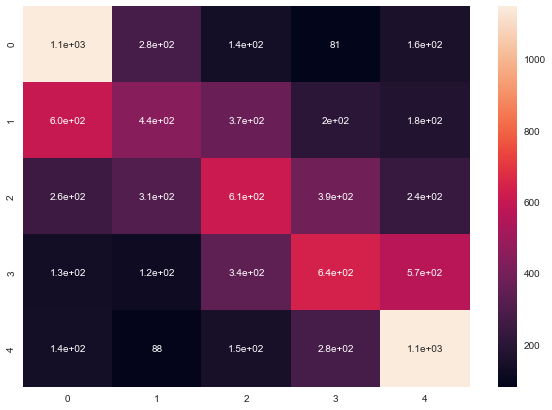

In [179]:
print(confusion_matrix_p(Y_test,LR_tfidf[1]))

## 3.2. GloVe Embedding and Logistic Regression

### 3.2.1. Chargement du modèle 

In [180]:
import struct 
def model_loading(embedding_file,dim):
    model = {}
    f = open(embedding_file, encoding="utf8")
    for line in tqdm(f):
        values = line.split()
        word = ''.join(values[:-dim])
        coefs = np.asarray(values[-dim:], dtype='float32')
        model[word] = coefs
    return model

In [39]:
glove_model = model_loading("gensim_glove_vectors.txt",300)

### 3.2.2. Fonctions d'aggrégations

In [56]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v_model))])
        else:
            self.dim=0
            
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v_model))])
        else:
            self.dim=0
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### 3.2.3. Vectorization avec aggrégation par la moyenne

In [44]:
import ast
X_train_list =[review for review in tqdm(X_train)]
X_train_list = [ast.literal_eval(review) for review in tqdm(X_train_list)]
X_test_list =[review for review in tqdm(X_test)]
X_test_list = [ast.literal_eval(review) for review in tqdm(X_test_list)]

In [45]:
fit = MeanEmbeddingVectorizer(glove_model).fit(X_train_list)
X_train_glove = fit.transform(X_train_list)
X_test_glove = fit.transform(X_test_list)

### 3.2.4. Vectorization avec aggrégation par poids tf-idf

In [46]:
fit = TfidfEmbeddingVectorizer(glove_model).fit(X_train_list)
X_train_glove_tfidf = fit.transform(X_train_list)
X_test_glove_tfidf = fit.transform(X_test_list)

### 3.2.5. Modélisation

#### a) Régression Logistique avec aggrégation par la moyenne

In [49]:
LR_golve_mean = LogReg("Logistic Regression + GloVe - Mean + Stop Words",[0.1, 1,10,100],['l1', 'l2'],X_train_glove,Y_train,X_test_glove,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  6.8min remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.3min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.411
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [50]:
LR_golve_mean[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + GloVe - Mean + Stop Words,0.418889,0.404055,0.418889,0.405855,7.413197


None


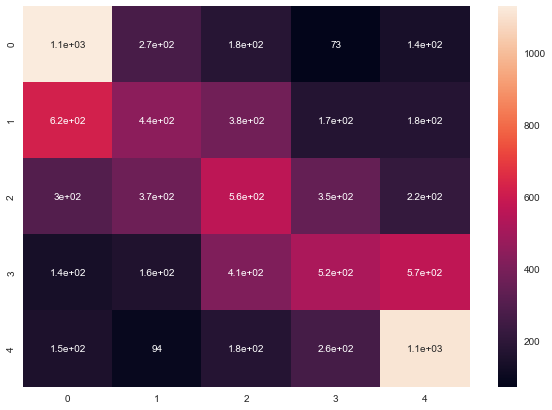

In [51]:
print(confusion_matrix_p(Y_test,LR_golve_mean[1]))

#### b) Régression Logistique avec aggrégation par poids tf-idf

In [52]:
LR_golve_tfidf = LogReg("Logistic Regression + GloVe - TFIDF + Stop Words",[0.1, 1,10,100],['l1', 'l2'],X_train_glove_tfidf,Y_train,X_test_glove_tfidf,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  4.3min remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.4min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.386
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [53]:
LR_golve_tfidf[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + GloVe - TFIDF + Stop Words,0.395556,0.379013,0.395556,0.380917,4.508175


None


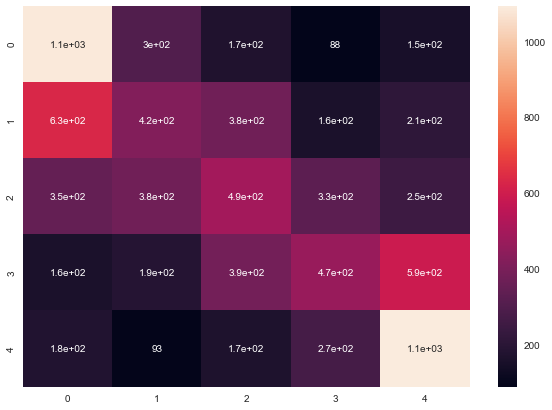

In [55]:
print(confusion_matrix_p(Y_test,LR_golve_tfidf[1]))

## 3.3. Word2Vec Embedding and Logistic Regression

In [57]:
w2v_model = model_loading("GoogleNews-vectors-negative300.txt",300)

In [58]:
fit = MeanEmbeddingVectorizer(w2v_model).fit(X_train_list)
X_train_w2v = fit.transform(X_train_list)
X_test_w2v = fit.transform(X_test_list)

In [59]:
LR_w2v_mean = LogReg("Logistic Regression + word2vec - Mean + Stop Words",[0.1, 1,10,100],['l1', 'l2'],X_train_w2v,Y_train,X_test_w2v,Y_test,truncated=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed: 13.5min remaining:   42.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.8min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.413
Best parameters set:
	lr__C: 100
	lr__penalty: 'l2'


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [60]:
LR_w2v_mean[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression + word2vec - Mean + Stop W...,0.419889,0.407416,0.419889,0.40848,14.851183


None


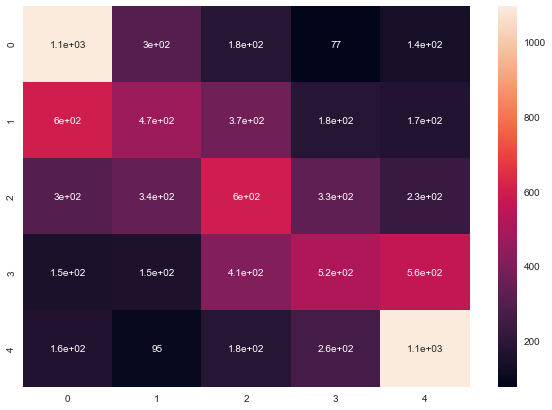

In [61]:
print(confusion_matrix_p(Y_test,LR_w2v_mean[1]))

## 3.4. Tableau récapitulatif régression logistique

In [62]:
recap_2 = pd.concat([LR_Count_w_stop[0],LR_tfidf[0],LR_golve_mean[0],LR_golve_tfidf[0],LR_w2v_mean[0]],ignore_index=True)
columnsTitles = ['Modèle', 'Accuracy', 'Precision','Recall', 'F1-score','Computing time (minutes)']
recap_2 = recap_2.reindex(columns = columnsTitles)
recap_2

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression With StopWords + Count,0.465444,0.452690,0.465444,0.453576,29.543277
1,Logistic Regression + TF-IDF + Stop Words,0.469778,0.460204,0.469778,0.462734,2.222186
2,Logistic Regression + GloVe - Mean + Stop Words,0.418889,0.404055,0.418889,0.405855,7.413197
3,Logistic Regression + GloVe - TFIDF + Stop Words,0.395556,0.379013,0.395556,0.380917,4.508175
4,Logistic Regression + word2vec - Mean + Stop W...,0.419889,0.407416,0.419889,0.408480,14.851183


# 4. Autres modèles 

## 4.1. Multinomial Naive Bayes

In [382]:
def NaiveBayesMultinomial(model_name,alpha_range,X_train,Y_train,X_test,Y_test,truncated):
    start = time.time()
    if truncated == True : 
        lsa = TruncatedSVD(n_components=100)
        X_train = lsa.fit_transform(X_train)
        X_test = lsa.transform(X_test)
    elif truncated == False:
        pass
    
    alpha = alpha_range
    cv_scores = [] 

    for a in tqdm(alpha):
        clf = naive_bayes.MultinomialNB(alpha = a)
        scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='f1_macro')
        cv_scores.append(scores.mean())
    print (max(cv_scores))
    optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
    end = time.time()
    clf = naive_bayes.MultinomialNB(alpha = optimal_alpha)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro')
    rec = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='macro')
    
    table = [[model_name,optimal_alpha,acc,prec,rec,f1,(end-start)/60]]

    table = pd.DataFrame(table, columns = ["Modèle","Optimal alpha", "Accuracy","Precision",'Recall',"F1-score","Computing time (minutes)"]) 
    return table, alpha, cv_scores, Y_pred

In [68]:
def parameter_optimal(param_range,cv_scores,nom_param):
    plt.plot(param_range, cv_scores)
    plt.xlabel(nom_param)
    plt.ylabel("F1-score (macro)")
    plt.show()

### 4.1.1. MNV - CountVectorizer

In [182]:
MultiNB_Count = NaiveBayesMultinomial("Naive Bayes + Count",np.linspace(0.1,4,40),X_train_count,Y_train,X_test_count,Y_test,truncated=False)

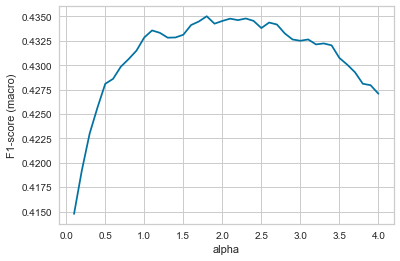

None


In [185]:
print(parameter_optimal(MultiNB_Count[1],MultiNB_Count[2],"alpha"))

In [186]:
MultiNB_Count[0]

,Modèle,Optimal alpha,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Naive Bayes + Count,1.8,0.438667,0.446469,0.438667,0.441051,0.15447


None


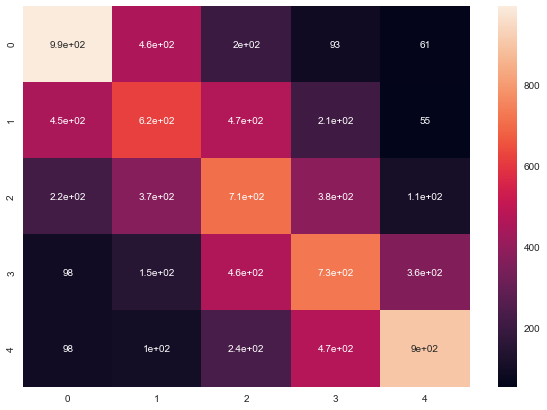

In [187]:
print(confusion_matrix_p(Y_test,MultiNB_Count[3]))

### 4.1.2. MNV - TF-IDF Vectorizer

In [383]:
MultiNB_tfidf = NaiveBayesMultinomial("Naive Bayes + TF-IDF", np.linspace(0.1,4,40), X_train_tfidf , Y_train , X_test_tfidf , Y_test , truncated=False)


0.43543945484659635


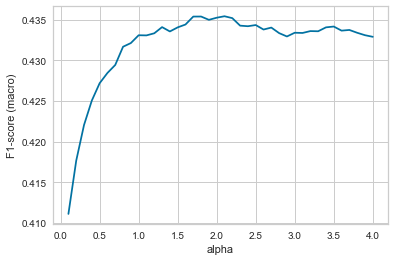

None


In [384]:
print(parameter_optimal(MultiNB_tfidf[1],MultiNB_tfidf[2],"alpha"))

In [385]:
MultiNB_tfidf[0]

,Modèle,Optimal alpha,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Naive Bayes + TF-IDF,2.1,0.426222,0.450745,0.426222,0.429763,0.142069


None


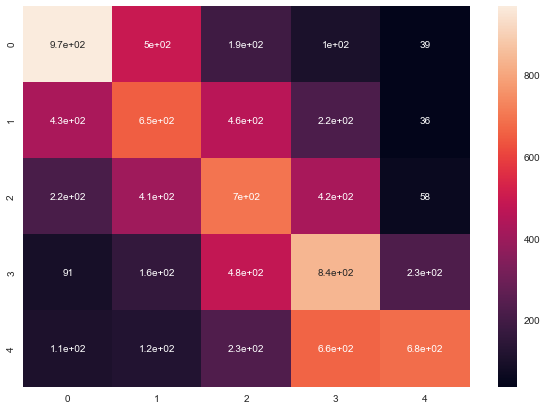

In [190]:
print(confusion_matrix_p(Y_test,MultiNB_tfidf[3]))

### 4.1.3. MNV - GloVe

In [191]:
MultiNB_GloVe = NaiveBayesMultinomial("Naive Bayes + GloVe", np.linspace(0.1,4,40), X_train_glove , Y_train , X_test_glove , Y_test , truncated=False)

C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input X must be non-negative

## 4.2. Support Vector Machines

In [79]:
def SVM(model_name,C_range,X_train,Y_train,X_test,Y_test,truncated):
    start = time.time()
    if truncated == True : 
        lsa = TruncatedSVD(n_components=100, n_iter=10, random_state=3)
        scl = StandardScaler(with_mean=False)
        svm_model = LinearSVC()
        clf = Pipeline([('svd', lsa), ('scl', scl), ('svm', svm_model)])
        #clf = Pipeline([('svd', lsa), ('svm', svm_model)])
    elif truncated == False : 
        scl = StandardScaler(with_mean=False)
        svm_model = LinearSVC()
        clf = Pipeline([('scl', scl), ('svm', svm_model)])
        #clf = Pipeline([('svm', svm_model)])
    params= {'svm__C': C_range}
    gs = GridSearchCV(estimator = clf, param_grid=params, scoring="f1_macro", verbose=10, n_jobs=-1, iid=True, refit=True, cv=5)
    gs.fit(X_train, Y_train)
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    end = time.time()
    best_model = gs.best_estimator_
    best_model.fit(X_train,Y_train)
    Y_pred = best_model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro')
    rec = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='macro')

    table = [[model_name,acc,prec,rec,f1,(end-start)/60]]
    
    table = pd.DataFrame(table, columns = ["Modèle", "Accuracy","Precision",'Recall',"F1-score","Computing time (minutes)"]) 
    return table, Y_pred

### 4.1.1. SVM - CountVectorizer

In [80]:
SVM_Count = SVM("SVM + Count",[1, 10,100,1000],X_train_count,Y_train,X_test_count,Y_test,truncated=True)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  8.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.1min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score: 0.378
Best parameters set:
	svm__C: 1


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [81]:
SVM_Count[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,SVM + Count,0.407222,0.390644,0.407222,0.381014,11.155772


None


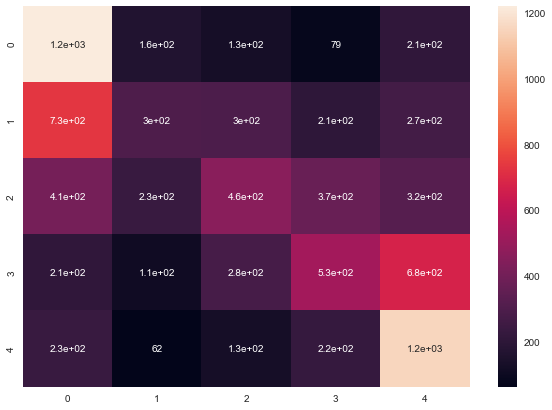

In [82]:
print(confusion_matrix_p(Y_test , SVM_Count[1]))

### 4.1.2. SVM - TF-IDF Vectorizer

In [83]:
SVM_TFIDF = SVM ("SVM + TFIDF",[0.1,1, 10,100,1000],X_train_tfidf,Y_train,X_test_tfidf,Y_test,truncated=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 11.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 12.2min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score: 0.417
Best parameters set:
	svm__C: 0.1


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [84]:
SVM_TFIDF[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,SVM + TFIDF,0.437667,0.420836,0.437667,0.41656,13.047214


None


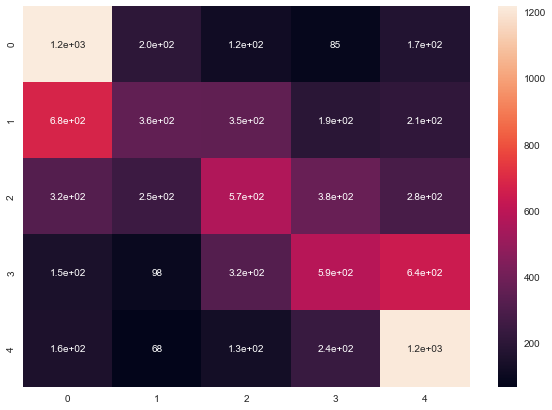

In [85]:
print(confusion_matrix_p(Y_test,SVM_TFIDF[1]))

### 4.1.3. SVM - GloVe with mean aggregation

In [86]:
SVM_GloVe = SVM("SVM + GloVe - Mean",[0.1, 1, 10],X_train_glove,Y_train,X_test_glove,Y_test,truncated=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.7min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.4min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score: 0.396
Best parameters set:
	svm__C: 0.1


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [87]:
SVM_GloVe[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,SVM + GloVe - Mean,0.414,0.393864,0.414,0.390925,8.583162


None


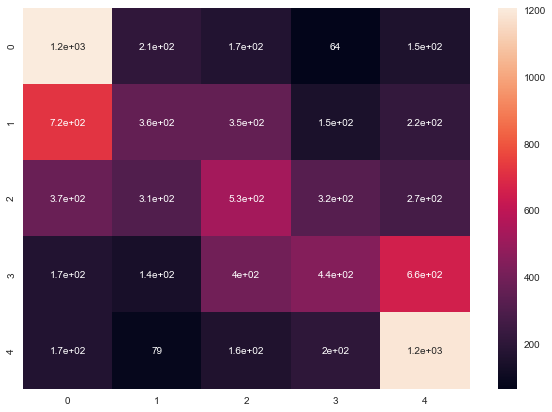

In [88]:
print(confusion_matrix_p(Y_test,SVM_GloVe[1]))

## 4.4. k - Plus Proches Voisins

In [193]:
def kPP(neighbors_range,X_train,Y_train,X_test,Y_test, model_name,truncated):
    start = time.time()
    if truncated == True : 
        lsa = TruncatedSVD(n_components=100)
        X_train = lsa.fit_transform(X_train)
        X_test = lsa.transform(X_test)
    elif truncated == False:
        pass
    neighbors = neighbors_range
    cv_scores = [] 
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='f1_macro')
        cv_scores.append(scores.mean())
        print(max(cv_scores))
    optimal_k = neighbors[cv_scores.index(max(cv_scores))]
    end = time.time()
    clf = KNeighborsClassifier(n_neighbors = optimal_k)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro')
    rec = recall_score(Y_test, Y_pred, average='macro')
    f1 = f1_score(Y_test, Y_pred, average='macro')
    
    table = [[model_name,optimal_k,acc,prec,rec,f1,(end-start)/60]]
    
    table = pd.DataFrame(table, columns = ["Modèle","Optimal k", "Accuracy","Precision",'Recall',"F1-score","Computing time (minutes)"])
    
    return table, neighbors, cv_scores, Y_pred

### 4.4.1. k - Plus Proches Voisins - Count Vectorizer

In [194]:
kNN_Count = kPP(range(30,50,1), X_train_count , Y_train , X_test_count , Y_test, "k-NN + Count", truncated = True)

0.3129193070523386
0.31474257053336896
0.31474257053336896
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251
0.3155545358961251



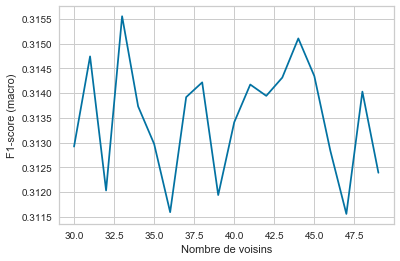

None


In [195]:
print(parameter_optimal(kNN_Count[1],kNN_Count[2],"Nombre de voisins"))

In [196]:
kNN_Count[0]

,Modèle,Optimal k,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,k-NN + Count,33,0.312111,0.307769,0.312111,0.308987,18.326535


None


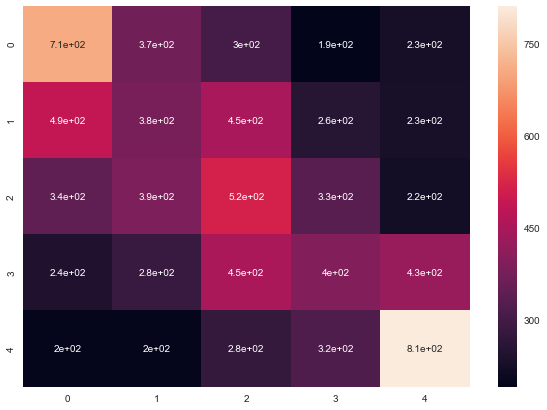

In [197]:
print(confusion_matrix_p(Y_test,kNN_Count[3]))

### 4.4.2. k - Plus Proches Voisins - TFIDF Vectorizer

In [198]:
kNN_tfidf = kPP(range(30,50,1), X_train_tfidf , Y_train , X_test_tfidf,Y_test, "k-NN + TF-IDF" , truncated = True)

0.3364614757294827
0.3373038065943124
0.3392582045443085
0.3392582045443085
0.3395581078094767
0.3411403055153796
0.34136305399655736
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364
0.34309488082622364



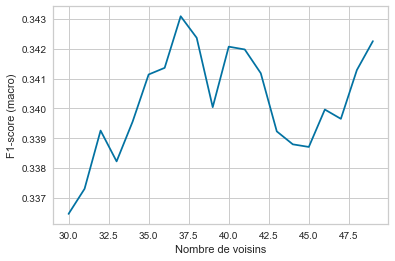

None


In [199]:
print(parameter_optimal(kNN_tfidf[1],kNN_tfidf[2],"Nombre de voisins"))

In [200]:
kNN_tfidf[0]

,Modèle,Optimal k,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,k-NN + TF-IDF,37,0.342222,0.340856,0.342222,0.34131,21.813297


None


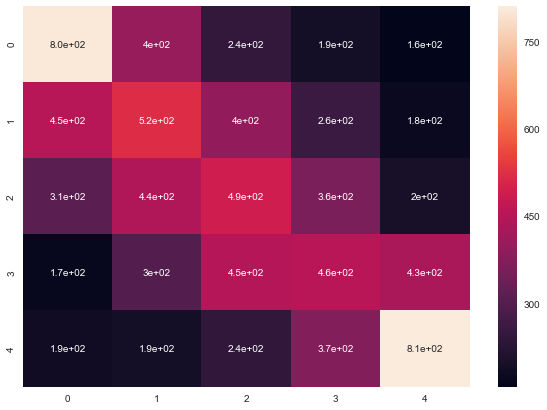

In [201]:
print(confusion_matrix_p(Y_test,kNN_tfidf[3]))

### 4.4.3. k - Plus Proches Voisins - Conclusion

## 4.5. Tableau récapitulatif de tous les modèles

In [209]:
#del LR_Count_w_stop[0]['Modèle']
#del LR_Count[0]['Modèle']
#del LR_Count_Bis[0]['Modèle']
#del LR_tfidf[0]['Modèle']
#del LR_golve_mean[0]['Modèle']
#del LR_golve_tfidf[0]['Modèle']
#del LR_w2v_mean[0]['Modèle']

LR_Count_w_stop[0]['Modèle'] = 'Logistic Regression'
LR_Count[0]['Modèle'] = 'Logistic Regression'
LR_Count_Bis[0]['Modèle'] = 'Logistic Regression'
LR_tfidf[0]['Modèle'] = 'Logistic Regression'
LR_golve_mean[0]['Modèle'] = 'Logistic Regression'
LR_golve_tfidf[0]['Modèle'] = 'Logistic Regression'
LR_w2v_mean[0]['Modèle'] = 'Logistic Regression'

LR_Count_w_stop[0]['StopWords'] = 'Conservés'
LR_Count[0]['StopWords'] = 'Retirés'
LR_Count_Bis[0]['StopWords'] = 'Conservés'
LR_tfidf[0]['StopWords'] = 'Conservés'
LR_golve_mean[0]['StopWords'] = 'Conservés'
LR_golve_tfidf[0]['StopWords'] = 'Conservés'
LR_w2v_mean[0]['StopWords'] = 'Conservés'

LR_Count_w_stop[0]['Embedding'] = 'CountVectorizer'
LR_Count[0]['Embedding'] = 'CountVectorizer'
LR_Count_Bis[0]['Embedding'] = 'CountVectorizer'
LR_tfidf[0]['Embedding'] = 'TF-IDF'
LR_golve_mean[0]['Embedding'] = 'GloVe - Mean Aggregated'
LR_golve_tfidf[0]['Embedding'] = 'GloVe - TFIDF Aggregated'
LR_w2v_mean[0]['Embedding'] = 'Word2Vec - Mean Aggregated'

LR_Count_w_stop[0]['Réduction'] = 'Oui'
LR_Count[0]['Réduction'] = 'Oui'
LR_Count_Bis[0]['Réduction'] = 'Non'
LR_tfidf[0]['Réduction'] = 'Oui'
LR_golve_mean[0]['Réduction'] = 'Oui'
LR_golve_tfidf[0]['Réduction'] = 'Oui'
LR_w2v_mean[0]['Réduction'] = 'Oui'

#del MultiNB_Count[0]['Modèle']
#del MultiNB_tfidf[0]['Modèle']

MultiNB_Count[0]['Modèle'] = 'Multinomial Naive Bayes'
MultiNB_tfidf[0]['Modèle'] = 'Multinomial Naive Bayes'

MultiNB_Count[0]['StopWords'] = 'Conservés'
MultiNB_tfidf[0]['StopWords'] = 'Conservés'

MultiNB_Count[0]['Embedding'] = 'CountVectorizer'
MultiNB_tfidf[0]['Embedding'] = 'TFIDF'

MultiNB_Count[0]['Réduction'] = 'Non'
MultiNB_tfidf[0]['Réduction'] = 'Non'

#del SVM_Count[0]['Modèle']
#del SVM_TFIDF[0]['Modèle']
#del SVM_GloVe[0]['Modèle']

SVM_Count[0]['Modèle'] = 'Support Vector Machine'
SVM_TFIDF[0]['Modèle'] = 'Support Vector Machine'
SVM_GloVe[0]['Modèle'] = 'Support Vector Machine'

SVM_Count[0]['StopWords'] = 'Conservés'
SVM_TFIDF[0]['StopWords'] = 'Conservés'
SVM_GloVe[0]['StopWords'] = 'Conservés'

SVM_Count[0]['Embedding'] = 'CountVectorizer'
SVM_TFIDF[0]['Embedding'] = 'TFIDF'
SVM_GloVe[0]['Embedding'] = 'TFIDF'

SVM_Count[0]['Réduction'] = 'Oui'
SVM_TFIDF[0]['Réduction'] = 'Oui'
SVM_GloVe[0]['Réduction'] = 'Oui'

#del kNN_Count[0]['Modèle']
#del kNN_tfidf[0]['Modèle']

kNN_Count[0]['Modèle'] = 'k-NN'
kNN_tfidf[0]['Modèle'] = 'k-NN'

kNN_Count[0]['StopWords'] = 'Conservés'
kNN_tfidf[0]['StopWords'] = 'Conservés'

kNN_Count[0]['Embedding'] = 'CountVectorizer'
kNN_tfidf[0]['Embedding'] = 'TFIDF'

kNN_Count[0]['Réduction'] = 'Oui'
kNN_tfidf[0]['Réduction'] = 'Oui'

In [210]:
recap_final = pd.concat([LR_Count_w_stop[0],LR_Count[0],LR_Count_Bis[0],LR_tfidf[0],LR_golve_mean[0],LR_golve_tfidf[0],LR_w2v_mean[0],
                    MultiNB_Count[0],MultiNB_tfidf[0],
                    SVM_Count[0],SVM_TFIDF[0],SVM_GloVe[0],
                    kNN_Count[0],kNN_tfidf[0]],ignore_index=True)
columnsTitles = ['Modèle','StopWords','Embedding','Réduction', 'Accuracy', 'Precision','Recall', 'F1-score','Computing time (minutes)']
recap_final = recap_final.reindex(columns = columnsTitles)
recap_final

C:\Users\Bastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,Modèle,StopWords,Embedding,Réduction,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression,Conservés,CountVectorizer,Oui,0.413778,0.399883,0.413778,0.395995,3.330849
1,Logistic Regression,Retirés,CountVectorizer,Oui,0.385222,0.371288,0.385222,0.364317,3.050929
2,Logistic Regression,Conservés,CountVectorizer,Non,0.465556,0.452797,0.465556,0.453664,5.021150
3,Logistic Regression,Conservés,TF-IDF,Oui,0.442889,0.429018,0.442889,0.430223,3.211547
4,Logistic Regression,Conservés,GloVe - Mean Aggregated,Oui,0.418889,0.404055,0.418889,0.405855,7.413197
5,Logistic Regression,Conservés,GloVe - TFIDF Aggregated,Oui,0.395556,0.379013,0.395556,0.380917,4.508175
6,Logistic Regression,Conservés,Word2Vec - Mean Aggregated,Oui,0.419889,0.407416,0.419889,0.408480,14.851183
7,Multinomial Naive Bayes,Conservés,CountVectorizer,Non,0.438667,0.446469,0.438667,0.441051,0.154470
8,Multinomial Naive Bayes,Conservés,TFIDF,Non,0.426222,0.450745,0.426222,0.429763,0.147118
9,Support Vector Machine,Conservés,CountVectorizer,Oui,0.407222,0.390644,0.407222,0.381014,11.155772


In [211]:
LR_tfidf_full = LogReg("Logistic Regression",[0.1, 1,10,100],['l1', 'l2'],X_train_tfidf,Y_train,X_test_tfidf,Y_test,truncated=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  2.2min remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.2min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.459
Best parameters set:
	lr__C: 1
	lr__penalty: 'l2'


In [212]:
LR_tfidf_full[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression,0.469778,0.460204,0.469778,0.462734,2.255735


None


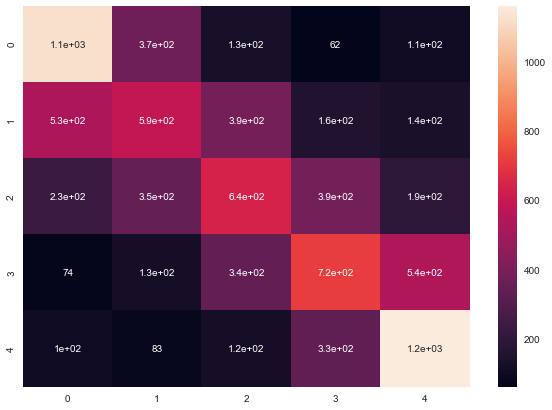

In [213]:
print(confusion_matrix_p(Y_test,LR_tfidf_full[1]))

In [217]:
LR_tfidf_full[0]['StopWords'] = 'Conservés'
LR_tfidf_full[0]['Embedding'] = 'Tf-IDFVectorizer'
LR_tfidf_full[0]['Réduction'] = 'Non'

In [218]:
recap_final_end = pd.concat([LR_Count_Bis[0],LR_tfidf_full[0]],ignore_index=True)
columnsTitles = ['Modèle','StopWords','Embedding','Réduction', 'Accuracy', 'Precision','Recall', 'F1-score','Computing time (minutes)']
recap_final_end = recap_final_end.reindex(columns = columnsTitles)
recap_final_end

C:\Users\Bastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Modèle,StopWords,Embedding,Réduction,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression,Conservés,CountVectorizer,Non,0.465556,0.452797,0.465556,0.453664,5.021150
1,Logistic Regression,Conservés,Tf-IDFVectorizer,Non,0.469778,0.460204,0.469778,0.462734,2.255735


# 5. Conclusion du travail jusqu'à présent - Choix du Modèle

# 6. Amélioration du modèle et augmentation du volume de données

In [235]:
rating_5_end = amazon[amazon['Positivité']==5]
rating_4_end = amazon[amazon['Positivité']==4]
rating_3_end = amazon[amazon['Positivité']==3]
rating_2_end = amazon[amazon['Positivité']==2]
rating_1_end = amazon[amazon['Positivité']==1]

In [236]:
X_train_5_end, X_test_5_end, y_train_5_end, y_test_5_end = train_test_split(rating_5_end['CleanedText_With_Stop'], rating_5_end['Positivité'], test_size = 0.3, shuffle = False)
X_train_4_end, X_test_4_end, y_train_4_end, y_test_4_end = train_test_split(rating_4_end['CleanedText_With_Stop'], rating_4_end['Positivité'], test_size = 0.3, shuffle = False)
X_train_3_end, X_test_3_end, y_train_3_end, y_test_3_end = train_test_split(rating_3_end['CleanedText_With_Stop'], rating_3_end['Positivité'], test_size = 0.3, shuffle = False)
X_train_2_end, X_test_2_end, y_train_2_end, y_test_2_end = train_test_split(rating_2_end['CleanedText_With_Stop'], rating_2_end['Positivité'], test_size = 0.3, shuffle = False)
X_train_1_end, X_test_1_end, y_train_1_end, y_test_1_end = train_test_split(rating_1_end['CleanedText_With_Stop'], rating_1_end['Positivité'], test_size = 0.3, shuffle = False)

X_train_end = pd.concat([X_train_5_end,X_train_4_end,X_train_3_end,X_train_2_end,X_train_1_end],axis=0,ignore_index=True)
X_test_end = pd.concat([X_test_5_end,X_test_4_end,X_test_3_end,X_test_2_end,X_test_1_end],axis=0,ignore_index=True)
Y_train_end = pd.concat([y_train_5_end,y_train_4_end,y_train_3_end,y_train_2_end,y_train_1_end],axis=0,ignore_index=True)
Y_test_end = pd.concat([y_test_5_end,y_test_4_end,y_test_3_end,y_test_2_end,y_test_1_end],axis=0,ignore_index=True)

In [388]:
X_test_end.shape

(58613,)

In [238]:
tf_idf_end = TfidfVectorizer()
tf_idf_end.fit(X_train_end) # On entraîne le tf-idf seulement sur le jeu d'entraînement
X_train_tfidf_end = tf_idf_end.transform(X_train_end)
X_test_tfidf_end = tf_idf_end.transform(X_test_end)

In [390]:
LR_end_full = LogReg("Logistic Regression",[0.1, 1,10],['l1', 'l2'],X_train_tfidf_end,Y_train_end,X_test_tfidf_end,Y_test_end,truncated=False)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 11.0min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.1min finished
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: 0.488
Best parameters set:
	lr__C: 1
	lr__penalty: 'l1'
              precision    recall  f1-score   support

           1       0.57      0.66      0.61     11706
           2       0.41      0.34      0.37     11688
           3       0.42      0.36      0.39     11725
           4       0.45      0.42      0.44     11743
           5       0.58      0.71      0.64     11751

    accuracy                           0.50     58613
   macro avg       0.49      0.50      0.49     58613
weighted avg       0.49      0.50      0.49     58613



In [240]:
LR_end_full[0]

,Modèle,Accuracy,Precision,Recall,F1-score,Computing time (minutes)
0,Logistic Regression,0.498081,0.486212,0.497959,0.488994,15.063307


None


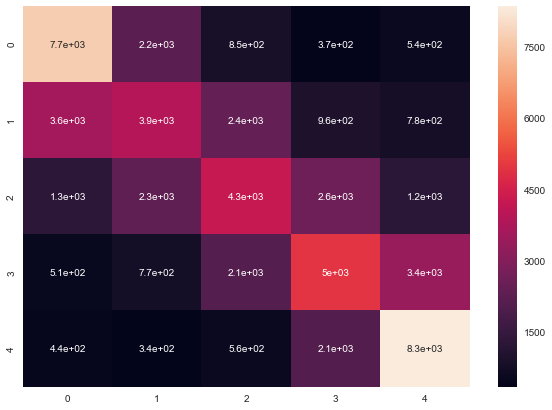

In [241]:
print(confusion_matrix_p(Y_test_end,LR_end_full[1]))

In [480]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(Y_test_end,LR_end_full[1]))

(array([0.56845524, 0.40856638, 0.41818003, 0.45238747, 0.58364208]), array([0.65795319, 0.3362423 , 0.36332623, 0.4219535 , 0.71049272]), array([0.60993863, 0.36889285, 0.38882804, 0.43664082, 0.64085048]), array([11706, 11688, 11725, 11743, 11751], dtype=int64))


In [497]:
app = pd.read_csv(r'C:\Users\Bastien\Desktop\3. Data - Bastien\2. Traitements\2. Scrapping complet trad et positivité\wb_complet_clean.csv',sep=',',encoding='utf-8')

In [498]:
app

,Unnamed: 0,Commentaires,Commentaries,Date,Marque,Nombre avis,Note,Note du commentaire,Prix,Produit,Site,intensivity,positivity
0,0,Good Bang for your buck. I bought this helmet ...,Good Bang for your buck. I bought this helmet ...,2019-09-18,AGV Helmets,94.0,NaN,4.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.502480,0.128919
1,1,Solid. Awesome helmet. Stylish and safe. Bang ...,Solid. Awesome helmet. Stylish and safe. Bang ...,2019-08-25,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.650000,0.500000
2,2,Great helmet. This is my first helmet and love...,Great helmet. This is my first helmet and love...,2019-08-11,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.641005,0.298413
3,3,AGV all the way!. I recently came from a shoei...,AGV all the way!. I recently came from a shoei...,2019-08-04,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.466558,0.170879
4,4,"Great buy!!. Overall a great starter helmet, p...","Great buy!!. Overall a great starter helmet, p...",2019-08-02,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.596032,0.534921
5,5,Awesome Helmet. I give 4 stars because the vid...,Awesome Helmet. I give 4 stars because the vid...,2019-06-27,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.583654,0.205910
6,6,Really good helmet. Really satisfied with this...,Really good helmet. Really satisfied with this...,2019-06-27,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.683333,0.512500
7,7,Good Helmet. Bought this as my first helmet be...,Good Helmet. Bought this as my first helmet be...,2019-06-06,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.546032,0.258135
8,8,Great helmet. I looked all over for a full fac...,Great helmet. I looked all over for a full fac...,2019-06-04,AGV Helmets,94.0,NaN,5.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.562889,0.301444
9,9,"Looks Great, But Cheap. I bought the Rossi Tar...","Looks Great, But Cheap. I bought the Rossi Tar...",2019-06-04,AGV Helmets,94.0,NaN,4.0,$199.95,AGV K3 SV Helmet Solid,Rev'Zilla,0.570321,0.214438


# 7. Comparaison avec une méthode non-supervisée : TextBlob

## 7.1. Préparation des données pour TextBlob

In [280]:
X_train_text_5_end = rating_5_end['reviewText'][X_train_5_end.index]
X_test_text_5_end = rating_5_end['reviewText'][X_test_5_end.index]

X_train_text_4_end = rating_4_end['reviewText'][X_train_4_end.index]
X_test_text_4_end = rating_4_end['reviewText'][X_test_4_end.index]

X_train_text_3_end = rating_3_end['reviewText'][X_train_3_end.index]
X_test_text_3_end = rating_3_end['reviewText'][X_test_3_end.index]

X_train_text_2_end = rating_2_end['reviewText'][X_train_2_end.index]
X_test_text_2_end = rating_2_end['reviewText'][X_test_2_end.index]

X_train_text_1_end = rating_1_end['reviewText'][X_train_1_end.index]
X_test_text_1_end = rating_1_end['reviewText'][X_test_1_end.index]

In [281]:
X_train_text_end = pd.concat([X_train_text_5_end,X_train_text_4_end,X_train_text_3_end,X_train_text_2_end,X_train_text_1_end],axis=0,ignore_index=True)
X_test_text_end = pd.concat([X_test_text_5_end,X_test_text_4_end,X_test_text_3_end,X_test_text_2_end,X_test_text_1_end],axis=0,ignore_index=True)

In [282]:
frame_train_end = {'Text':X_train_text_end}
frame_test_end = {'Text':X_test_text_end}

X_train_tb_end = pd.DataFrame(frame_train_end)
X_test_tb_end = pd.DataFrame(frame_test_end) 

## 7.2. Analyse de sentiment avec TextBlob

### 7.2.1. Obtention de la note de positivité avec TextBlob

In [283]:
class SentimentAnalyzer() :
    def sentiment_analysis(self,expression):
        blob = TextBlob(expression)
        return (blob.sentiment[0], blob.sentiment[1])

    def run(self,df) :
        df['TextBlobPositivité']=0
        #scraping_mb_ic_dafy_trad['intensivity']=0
        for index, row in tqdm(df.iterrows()):
            positivity, intensity = self.sentiment_analysis(str(row['Text']))
            if positivity*intensity > -1:
                df.loc[index,'TextBlobPositivité'] = positivity
                #scraping_mb_ic_dafy_trad.loc[index,'intensivity'] = intensity

In [284]:
from textblob import TextBlob
sentiment_analyser = SentimentAnalyzer()
sentiment_analyser.run(X_train_tb_end)
sentiment_analyser.run(X_test_tb_end)

In [285]:
X_train_tb_done_end = np.array(X_train_tb_end['TextBlobPositivité'])
X_test_tb_done_end = np.array(X_test_tb_end['TextBlobPositivité'])

In [286]:
X_train_tb_done_end = X_train_tb_done_end.reshape(-1,1)
X_test_tb_done_end = X_test_tb_done_end.reshape(-1,1)

In [287]:
X_train_tb_done_end

array([[ 0.4075    ],
       [ 0.42159091],
       [ 0.53166667],
       ...,
       [ 0.27857143],
       [ 0.08148148],
       [-0.02391215]])

### 7.2.2. Premières comparaisons TextBlob / Notes en étoiles - jeu d'entrainement

In [342]:
TB = pd.concat([X_train_tb_end['TextBlobPositivité'],pd.DataFrame(Y_train_end)],axis=1)

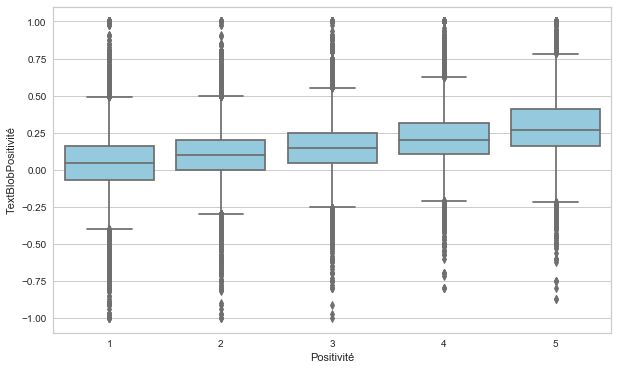

In [393]:
plt.figure(figsize=(10,6))
sn.boxplot(x ='Positivité' , y ='TextBlobPositivité', data = TB , color="skyblue")
plt.show();

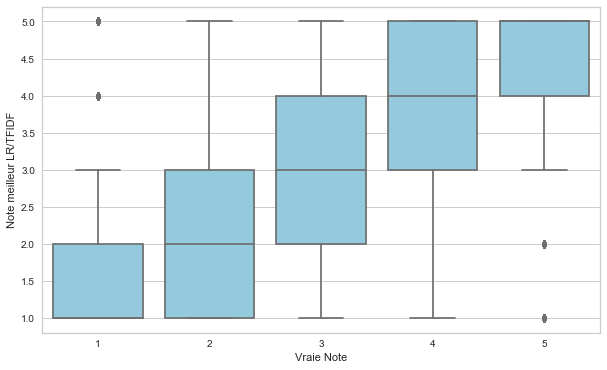

In [395]:
plt.figure(figsize=(10,6))
sn.boxplot(x ='Vraie Note' , y ='Note meilleur LR/TFIDF', data = Y_TextBlob , color="skyblue")
plt.show();

In [482]:
Y_TextBlob.groupby(['Note étoiles TextBlob']).count()

,Note TextBlob,Vraie Note,Note meilleur LR/TFIDF
Note étoiles TextBlob,,,
1,15281,15281,15281
2,22086,22086,22086
4,4617,4617,4617
5,16629,16629,16629


In [484]:
len(Y_TextBlob['Vraie Note'])

58613

In [416]:
note_5 = Y_TextBlob[Y_TextBlob['Vraie Note']==5]['Note TextBlob']
note_4 = Y_TextBlob[Y_TextBlob['Vraie Note']==4]['Note TextBlob']
note_3 = Y_TextBlob[Y_TextBlob['Vraie Note']==3]['Note TextBlob']
note_2 = Y_TextBlob[Y_TextBlob['Vraie Note']==2]['Note TextBlob']
note_1 = Y_TextBlob[Y_TextBlob['Vraie Note']==1]['Note TextBlob']

In [512]:
import scipy
from scipy import stats
print(stats.shapiro(note_5))
print(stats.shapiro(note_4))
print(stats.shapiro(note_3))
print(stats.shapiro(note_2))
print(stats.shapiro(note_1))

C:\Users\Bastien\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.983443558216095, 1.0184998482246486e-34)
(0.9729025959968567, 3.5971331579218054e-42)
(0.9742953777313232, 2.6013704691725904e-41)
(0.9747620820999146, 5.648634109693338e-41)
(0.9671810269355774, 2.802596928649634e-45)


In [516]:
stats.kruskal(note_1,note_2,note_3,note_4,note_5)

KruskalResult(statistic=-922098.8970271356, pvalue=1.0)

In [515]:
stats.ks_2samp(note_4,note_3)

Ks_2sampResult(statistic=0.144495609324577, pvalue=3.6637521651517086e-107)

### 7.2.3. Tests Statistiques comparant les deux distributions

In [347]:
from scipy import stats
stats.ks_2samp(np.array(TB['TextBlobPositivité']),np.array(TB['Positivité']))

Ks_2sampResult(statistic=0.9978209046901736, pvalue=0.0)

In [349]:
from scipy.stats import mannwhitneyu
mannwhitneyu(np.array(TB['TextBlobPositivité']),np.array(TB['Positivité']))

MannwhitneyuResult(statistic=4069637.0, pvalue=0.0)

## 7.3. Transposition note de posisitivté de TextBlob vers notation étoiles

### 7.3.1. Premier modèle : arbre de décision

In [288]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [356]:
clf_dt = OneVsRestClassifier(DecisionTreeClassifier())
clf_dt.fit(X_train_tb_done_end, Y_train_end)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best'),
                    n_jobs=None)

In [357]:
Y_pred_tb_dt_end = clf_dt.predict(X_test_tb_done_end)
print(f1_score(Y_test_end, Y_pred_tb_dt_end, average='macro'))
print(accuracy_score(Y_test_end, Y_pred_tb_dt_end))

0.2821234212685465
0.29162472489038266


In [358]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


Y_train_bin_end = label_binarize(Y_train_end, classes=[1, 2, 3, 4, 5])
Y_test_bin_end = label_binarize(Y_test_end, classes=[1, 2, 3, 4, 5])
n_classes = Y_train_bin_end.shape[1]


classifier = OneVsRestClassifier(DecisionTreeClassifier())
classifier.fit(X_train_tb_done_end, Y_train_bin_end)
Y_score_end = classifier.predict(X_test_tb_done_end)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0,n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin_end[:, i], Y_score_end[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin_end.ravel(), Y_score_end.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### 7.3.2. Amélioration du modèle par recherche de paramètres - max_depth

In [295]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in tqdm(max_depths) :
    dt = OneVsRestClassifier(DecisionTreeClassifier(max_depth=max_depth))
    dt.fit(X_train_tb_done_end, Y_train_bin_end)
    Y_train_pred_end = dt.predict(X_train_tb_done_end)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_train_bin_end[:, i], Y_train_pred_end[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y_train_bin_end.ravel(), Y_train_pred_end.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Add auc score to previous train results
    train_results.append(roc_auc["micro"])
    
    Y_score_end = dt.predict(X_test_tb_done_end)
    for i in range(0,n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_bin_end[:, i], Y_score_end[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin_end.ravel(), Y_score_end.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Add auc score to previous test results
    test_results.append(roc_auc["micro"])

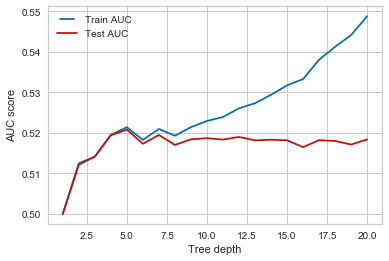

In [296]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

### 7.3.3. Amélioration du modèle par recherche de paramètres - min_samples_split

In [299]:
min_samples_splits = np.linspace(0.01, 0.3, 30, endpoint=True)
train_results = []
test_results = []
for min_samples_split in tqdm(min_samples_splits):
    dt = OneVsRestClassifier(DecisionTreeClassifier(max_depth=5,min_samples_split=min_samples_split))
    dt.fit(X_train_tb_done_end, Y_train_bin_end)
    Y_train_pred_end = dt.predict(X_train_tb_done_end)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_train_bin_end[:, i], Y_train_pred_end[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y_train_bin_end.ravel(), Y_train_pred_end.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Add auc score to previous train results
    train_results.append(roc_auc["micro"])
    
    Y_score_end = dt.predict(X_test_tb_done_end)
    for i in range(0,n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_bin_end[:, i], Y_score_end[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin_end.ravel(), Y_score_end.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Add auc score to previous test results
    test_results.append(roc_auc["micro"])

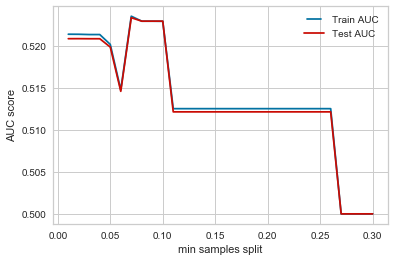

In [300]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

### 7.3.4. Modèle final et valeur de TextBlob en étoiles

In [485]:
clf_dt = OneVsRestClassifier(DecisionTreeClassifier(criterion='gini',max_depth=1))
clf_dt.fit(X_train_tb_done_end, Y_train_end)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=1,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best'),
                    n_jobs=None)

In [486]:
Y_train_pred_end = clf_dt.predict(X_train_tb_done_end)

In [487]:
print(f1_score(Y_train_end, Y_train_pred_end, average='macro'))

C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.26331762984040313


In [488]:
print(f1_score(Y_train_end, Y_train_pred_end, average='macro'))
print(accuracy_score(Y_train_end, Y_train_pred_end))

0.26331762984040313
0.31228337013908186


In [489]:
Y_pred_tb_dt_end = clf_dt.predict(X_test_tb_done_end)

In [490]:
print(f1_score(Y_test_end, Y_pred_tb_dt_end, average='macro'))
print(accuracy_score(Y_test_end, Y_pred_tb_dt_end))
acc_tb = accuracy_score(Y_test_end, Y_pred_tb_dt_end)
prec_tb = precision_score(Y_test_end, Y_pred_tb_dt_end, average='macro')
rec_tb = recall_score(Y_test_end, Y_pred_tb_dt_end, average='macro')
f1_tb = f1_score(Y_test_end, Y_pred_tb_dt_end, average='macro')

C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.26419547267965354
0.31341170047600364


C:\Users\Bastien\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [491]:
Y_pred_tb_dt_pd_end = pd.DataFrame(Y_pred_tb_dt_end)

In [492]:
X_test_tb_done_pd_end = pd.DataFrame(X_test_tb_done_end)

In [493]:
Y_TextBlob = pd.concat([X_test_tb_done_pd_end,Y_pred_tb_dt_pd_end,Y_test_end,pd.DataFrame(LR_end_full[1])],axis = 1)
Y_TextBlob.columns = ['Note TextBlob','Note étoiles TextBlob','Vraie Note','Note meilleur LR/TFIDF']
Y_TextBlob

,Note TextBlob,Note étoiles TextBlob,Vraie Note,Note meilleur LR/TFIDF
0,0.156818,2,5,5
1,0.418056,5,5,5
2,-0.044167,1,5,5
3,0.335417,5,5,4
4,0.061988,2,5,5
5,0.700000,5,5,5
6,0.407292,5,5,5
7,-0.006937,1,5,4
8,0.342000,5,5,5
9,0.328500,5,5,5


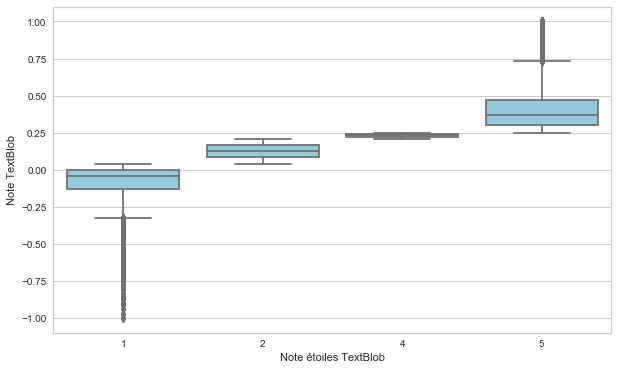

In [494]:
plt.figure(figsize=(10,6))
sn.boxplot(x ='Note étoiles TextBlob' , y ='Note TextBlob', data = Y_TextBlob , color="skyblue")
plt.show();

In [446]:
len(Y_pred_tb_dt_pd_end)

58613

In [447]:
Y_TextBlob['Note TextBlob'].min()
Y_TextBlob['Note étoiles TextBlob'][Y_TextBlob.index[Y_TextBlob['Note TextBlob'] == Y_TextBlob['Note TextBlob'].min()].tolist()]

37338    1
51576    1
53177    1
57310    1
Name: Note étoiles TextBlob, dtype: int64

### 7.3.5. Visualisation de l'arbre de décision

In [469]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(clf_dt, out_file=None, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

NotFittedError: This OneVsRestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### 7.3.6. Tableau récapitulatif TextBlob - meilleure configuration de Machine Learning

In [448]:
TextBlob = [['Unsupervised TextBlob', acc_tb,prec_tb,rec_tb,f1_tb]]
TextBlob = pd.DataFrame(TextBlob, columns = ["Modèle", "Accuracy","Precision",'Recall',"F1-score"]) 
table_comp = pd.concat([TextBlob,LR_end_full[0]],axis=0,ignore_index=True)
columnsTitles = ["Modèle", "Accuracy","Precision",'Recall',"F1-score"]
table_comp = table_comp.reindex(columns = columnsTitles)

C:\Users\Bastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [449]:
table_comp

,Modèle,Accuracy,Precision,Recall,F1-score
0,Unsupervised TextBlob,0.313412,0.249442,0.313504,0.264195
1,Logistic Regression,0.498115,0.486246,0.497994,0.489030


# 8. Conclusion de cette partie